## Otros modelos

In [1]:
# =============================================================================
# IMPORTACIÓN DE LIBRERÍAS NECESARIAS
# =============================================================================

# pandas: para manipulación y análisis de datos estructurados (DataFrames)
import pandas as pd

# numpy: para operaciones numéricas y manejo de arrays
import numpy as np

# matplotlib.pyplot: para visualización de datos (gráficos)
import matplotlib.pyplot as plt

# mean_squared_error: métrica para evaluar el error cuadrático medio en modelos de regresión
from sklearn.metrics import mean_squared_error

Cargamos datos

In [2]:
# =============================================================================
# CARGA DEL DATASET
# =============================================================================

# Leemos el archivo CSV con los datos de la serie temporal
# index_col=0: usa la primera columna como índice (las fechas)
df = pd.read_csv('data/jj.csv', index_col=0)

# Mostramos el número total de registros en el dataset
print(len(df))

# Visualizamos las primeras 5 filas para entender la estructura de los datos
# Este dataset contiene información trimestral de Johnson & Johnson
df.head()

84


,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


<Axes: xlabel='date'>

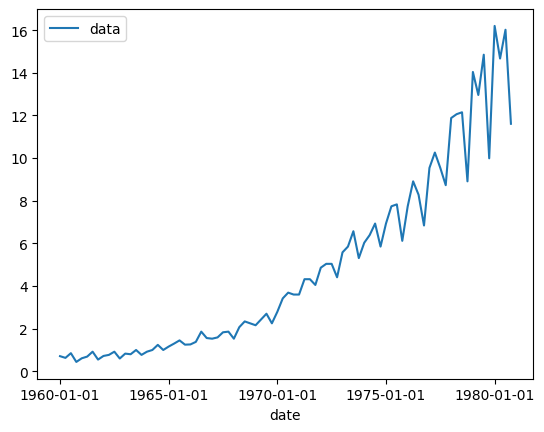

In [3]:
# =============================================================================
# VISUALIZACIÓN DE LA SERIE TEMPORAL
# =============================================================================

# Graficamos la serie temporal completa para observar:
# - Tendencia general (crecimiento/decrecimiento)
# - Estacionalidad (patrones que se repiten)
# - Valores atípicos (outliers)
df.plot()

### Preparamos las features del dataset

In [4]:
# =============================================================================
# INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING) - CREACIÓN DE LAGS
# =============================================================================

# Creamos features basadas en valores históricos (LAGS)
# Un LAG es el valor de la serie en momentos anteriores en el tiempo
# 
# ¿Por qué hacemos esto?
# Para predecir el valor actual, usaremos los 12 valores anteriores (1 año de datos trimestrales)
# 
# Ejemplo: Si estamos en 1963-01-01:
#   t-1  = valor del trimestre anterior (1962-10-01)
#   t-2  = valor de hace 2 trimestres (1962-07-01)
#   t-12 = valor de hace 12 trimestres (1960-01-01)

for i in range(12, 0, -1):  # Iteramos desde 12 hasta 1 (en orden descendente)
    # shift(i): desplaza los valores i posiciones hacia abajo
    # Esto crea una nueva columna con el valor de i trimestres atrás
    df['t-'+str(i)] = df['data'].shift(i)

In [5]:
# =============================================================================
# LIMPIEZA DE DATOS - ELIMINACIÓN DE VALORES NULOS
# =============================================================================

# Al crear los lags, las primeras 12 filas tendrán valores NaN (nulos)
# porque no tienen suficiente historia previa
# 
# Ejemplo: La primera fila (1960-01-01) no puede tener t-1, t-2, etc.
# porque no hay datos anteriores a 1960-01-01

# dropna(): elimina todas las filas que contienen valores NaN
# inplace=True: modifica el DataFrame original sin crear una copia
df.dropna(inplace=True)

# Mostramos las primeras 15 filas para verificar:
# - Que no hay NaN
# - Que ahora tenemos 13 columnas (data + 12 lags)
# - Que los datos empiezan en 1963 (después de perder las primeras 12 filas)
df.head(15)

,data,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
date,,,,,,,,,,,,,
1963-01-01,0.83,0.71,0.63,0.85,0.44,0.61,0.69,0.92,0.55,0.72,0.77,0.92,0.60
1963-04-02,0.80,0.63,0.85,0.44,0.61,0.69,0.92,0.55,0.72,0.77,0.92,0.60,0.83
1963-07-02,1.00,0.85,0.44,0.61,0.69,0.92,0.55,0.72,0.77,0.92,0.60,0.83,0.80
1963-10-01,0.77,0.44,0.61,0.69,0.92,0.55,0.72,0.77,0.92,0.60,0.83,0.80,1.00
1964-01-01,0.92,0.61,0.69,0.92,0.55,0.72,0.77,0.92,0.60,0.83,0.80,1.00,0.77
1964-04-01,1.00,0.69,0.92,0.55,0.72,0.77,0.92,0.60,0.83,0.80,1.00,0.77,0.92
1964-07-02,1.24,0.92,0.55,0.72,0.77,0.92,0.60,0.83,0.80,1.00,0.77,0.92,1.00
1964-10-01,1.00,0.55,0.72,0.77,0.92,0.60,0.83,0.80,1.00,0.77,0.92,1.00,1.24
1965-01-01,1.16,0.72,0.77,0.92,0.60,0.83,0.80,1.00,0.77,0.92,1.00,1.24,1.00


In [6]:
# =============================================================================
# VERIFICACIÓN DE LOS ÚLTIMOS REGISTROS
# =============================================================================

# Mostramos las últimas 30 filas para ver:
# - Cómo terminan nuestros datos (1980)
# - Que la estructura de lags está correcta
# - Los valores más recientes que usaremos para test
df.tail(30)

,data,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
date,,,,,,,,,,,,,
1973-07-02,6.570000,3.690000,3.600000,3.600000,4.320000,4.320000,4.050000,4.860000,5.040000,5.040000,4.410000,5.580000,5.850000
1973-10-01,5.310000,3.600000,3.600000,4.320000,4.320000,4.050000,4.860000,5.040000,5.040000,4.410000,5.580000,5.850000,6.570000
1974-01-01,6.030000,3.600000,4.320000,4.320000,4.050000,4.860000,5.040000,5.040000,4.410000,5.580000,5.850000,6.570000,5.310000
1974-04-02,6.390000,4.320000,4.320000,4.050000,4.860000,5.040000,5.040000,4.410000,5.580000,5.850000,6.570000,5.310000,6.030000
1974-07-02,6.930000,4.320000,4.050000,4.860000,5.040000,5.040000,4.410000,5.580000,5.850000,6.570000,5.310000,6.030000,6.390000
1974-10-01,5.850000,4.050000,4.860000,5.040000,5.040000,4.410000,5.580000,5.850000,6.570000,5.310000,6.030000,6.390000,6.930000
1975-01-01,6.930000,4.860000,5.040000,5.040000,4.410000,5.580000,5.850000,6.570000,5.310000,6.030000,6.390000,6.930000,5.850000
1975-04-02,7.740000,5.040000,5.040000,4.410000,5.580000,5.850000,6.570000,5.310000,6.030000,6.390000,6.930000,5.850000,6.930000
1975-07-02,7.830000,5.040000,4.410000,5.580000,5.850000,6.570000,5.310000,6.030000,6.390000,6.930000,5.850000,6.930000,7.740000


### Dividimos en train test

In [7]:
# =============================================================================
# DIVISIÓN DEL DATASET EN TRAIN Y TEST
# =============================================================================

# PREPARACIÓN DE VARIABLES X (features) e Y (target)
# ===================================================

# X: Todas las columnas EXCEPTO la primera (columna 'data')
# Son los LAGS: t-12, t-11, ..., t-2, t-1
# iloc[:,1:] significa: todas las filas, desde la columna 1 en adelante
X = df.iloc[:, 1:].values  # Shape: (72, 12) - 72 filas, 12 características

# Y: Solo la primera columna (columna 'data')
# Es el valor ACTUAL que queremos predecir
Y = df.iloc[:, 0].values   # Shape: (72,) - 72 valores objetivo


# DIVISIÓN TEMPORAL (NO ALEATORIA)
# ================================
# En series temporales NO usamos train_test_split aleatorio
# porque debemos respetar el orden temporal

# TRAIN: Primeras 60 observaciones (años 1963-1978)
X_train = X[:60]   # Features de entrenamiento
y_train = Y[:60]   # Target de entrenamiento

# TEST: Últimas 12 observaciones (4 trimestres de 1978-1980)
X_test = X[60:]    # Features de prueba
y_test = Y[60:]    # Target de prueba


# VERIFICACIÓN DE DIMENSIONES
# ============================
print("Shape X_train:", X_train.shape)  # Esperado: (60, 12)
print("Shape X_test:", X_test.shape)    # Esperado: (12, 12)
print("Shape y_train:", y_train.shape)  # Esperado: (60,)
print("Shape y_test:", y_test.shape)    # Esperado: (12,)

Shape X_train: (60, 12)
Shape X_test: (12, 12)
Shape y_train: (60,)
Shape y_test: (12,)


In [8]:
# =============================================================================
# VISUALIZACIÓN DEL CONJUNTO DE TEST
# =============================================================================

# Convertimos X_test a DataFrame para visualizarlo mejor
# Cada fila es una predicción que haremos
# Cada columna representa un lag (t-12 hasta t-1)
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11
0,6.930000,7.740000,7.830000,6.120000,7.740000,8.910000,8.280000,6.840000,9.540000,10.260000,9.540000,8.729999
1,7.740000,7.830000,6.120000,7.740000,8.910000,8.280000,6.840000,9.540000,10.260000,9.540000,8.729999,11.880000
2,7.830000,6.120000,7.740000,8.910000,8.280000,6.840000,9.540000,10.260000,9.540000,8.729999,11.880000,12.060000
3,6.120000,7.740000,8.910000,8.280000,6.840000,9.540000,10.260000,9.540000,8.729999,11.880000,12.060000,12.150000
4,7.740000,8.910000,8.280000,6.840000,9.540000,10.260000,9.540000,8.729999,11.880000,12.060000,12.150000,8.910000
5,8.910000,8.280000,6.840000,9.540000,10.260000,9.540000,8.729999,11.880000,12.060000,12.150000,8.910000,14.040000
6,8.280000,6.840000,9.540000,10.260000,9.540000,8.729999,11.880000,12.060000,12.150000,8.910000,14.040000,12.960000
7,6.840000,9.540000,10.260000,9.540000,8.729999,11.880000,12.060000,12.150000,8.910000,14.040000,12.960000,14.850000
8,9.540000,10.260000,9.540000,8.729999,11.880000,12.060000,12.150000,8.910000,14.040000,12.960000,14.850000,9.990000
9,10.260000,9.540000,8.729999,11.880000,12.060000,12.150000,8.910000,14.040000,12.960000,14.850000,9.990000,16.200000


### Modelos de predicción

Implementa varios modelos de regresión para predecir la serie temporal. ¿Cuál ofrece mejor resultados?

NOTA: Para predecir los resultados de test, hay que iterar e ir prediciendo cada muestra en función del lag utilizado. 

Por ejemplo, para un lag = 3 (predecimos usando los últimos 3 registros):



### Árbol de decisión

In [9]:
# =============================================================================
# MODELO 1: ÁRBOL DE DECISIÓN PARA REGRESIÓN
# =============================================================================

# Importamos el modelo de Árbol de Decisión para regresión
from sklearn.tree import DecisionTreeRegressor

# Creamos una instancia del modelo
# Un árbol de decisión divide el espacio de features mediante reglas jerárquicas
tree = DecisionTreeRegressor()

# Entrenamos el modelo con los datos de train
# El árbol aprende patrones en los 12 lags para predecir el valor actual
tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [10]:
# =============================================================================
# FUNCIÓN DE PREDICCIÓN ITERATIVA PARA SERIES TEMPORALES
# =============================================================================

def prediction(model, x_test):
    """
    Realiza predicciones iterativas para series temporales.
    
    ¿POR QUÉ NECESITAMOS ESTA FUNCIÓN?
    ==================================
    En series temporales, NO podemos hacer predict(X_test) directamente porque:
    - La primera predicción usa los valores reales (históricos)
    - La segunda predicción debe usar la PRIMERA PREDICCIÓN como t-1
    - La tercera predicción usa la segunda predicción como t-1, y así sucesivamente
    
    EJEMPLO PASO A PASO:
    ====================
    Si queremos predecir 3 valores futuros con lag=3:
    
    1) Predicción 1:
       Input: [valor_real_t-3, valor_real_t-2, valor_real_t-1]
       Output: predicción_1
       
    2) Predicción 2:
       Input: [valor_real_t-2, valor_real_t-1, predicción_1]  ← usamos predicción_1
       Output: predicción_2
       
    3) Predicción 3:
       Input: [valor_real_t-1, predicción_1, predicción_2]    ← usamos predicciones previas
       Output: predicción_3
    
    Args:
        model: Modelo de ML ya entrenado
        x_test: Array con los datos de test
    
    Returns:
        preds_out: Lista con todas las predicciones
    """
    
    # Inicializamos con la primera fila de X_test
    # Estos son los 12 valores históricos reales para la primera predicción
    preds = x_test[0]
    
    # Lista para almacenar las predicciones
    preds_out = []
    
    # Iteramos sobre cada muestra del conjunto de test
    for i in range(len(X_test)):
        
        # PASO 1: Predecir el siguiente valor
        # El modelo recibe los 12 lags actuales y devuelve una predicción
        pred = model.predict([preds])[0]
        
        # Guardamos la predicción
        preds_out.append(pred)
        
        # PASO 2: Actualizar los lags para la siguiente iteración
        # Eliminamos el valor más antiguo (t-12)
        preds2 = np.array([preds[1:]])  # Quitamos el primer elemento
        
        # PASO 3: Añadir la predicción como el nuevo t-1
        # np.c_: concatena arrays por columnas
        # Ahora: [antiguo_t-11, antiguo_t-10, ..., antiguo_t-1, nueva_predicción]
        # Esto se convierte en: [nuevo_t-12, nuevo_t-11, ..., nuevo_t-2, nuevo_t-1]
        preds = np.c_[preds2, np.array([pred])][0]
    
    return preds_out

In [11]:
# =============================================================================
# PREDICCIONES CON EL ÁRBOL DE DECISIÓN
# =============================================================================

# Usamos nuestra función personalizada para hacer predicciones iterativas
# El árbol de decisión predice los 12 valores futuros, usando sus propias predicciones
preds = prediction(tree, X_test)

# Mostramos las predicciones
preds

[np.float64(10.26),
 np.float64(9.54),
 np.float64(9.54),
 np.float64(8.729999),
 np.float64(9.54),
 np.float64(9.54),
 np.float64(9.54),
 np.float64(9.54),
 np.float64(9.54),
 np.float64(9.54),
 np.float64(9.54),
 np.float64(9.54)]

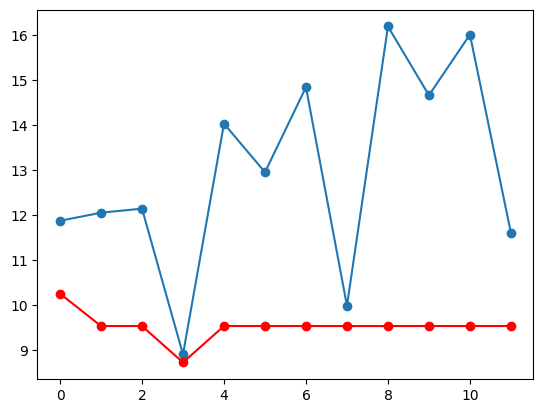

In [12]:
# =============================================================================
# VISUALIZACIÓN DE RESULTADOS - ÁRBOL DE DECISIÓN
# =============================================================================

# Graficamos los valores reales vs las predicciones
# 'o-': círculos conectados con líneas
plt.plot(y_test, 'o-')                  # Azul: valores REALES
plt.plot(preds, 'o-', color='red')      # Rojo: valores PREDICHOS

# OBSERVACIÓN: Si las predicciones son constantes (todas iguales),
# el árbol ha sufrido OVERFITTING y no generaliza bien

### Random Forest

MSE: 15.954340062093864


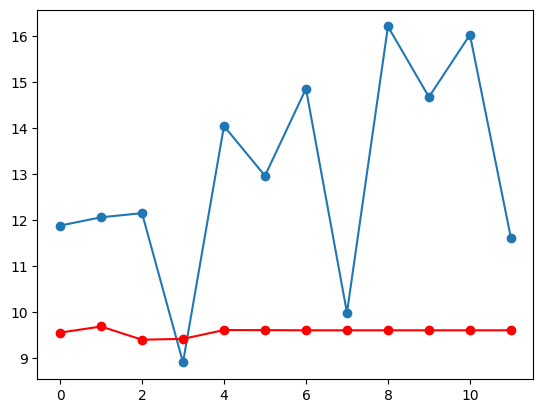

In [13]:
# =============================================================================
# MODELO 2: RANDOM FOREST (BOSQUE ALEATORIO)
# =============================================================================

# Importamos Random Forest, un ensemble de árboles de decisión
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con parámetros específicos:
# - n_estimators=200: usamos 200 árboles diferentes (más árboles = más robusto)
# - max_depth=5: limitamos la profundidad de cada árbol a 5 niveles
#                (evita overfitting que vimos con el árbol único)
rfr = RandomForestRegressor(n_estimators=200, max_depth=5)

# Entrenamos el modelo con los datos de train
rfr.fit(X_train, y_train)

# Hacemos predicciones iterativas (igual que con el árbol)
pred2 = prediction(rfr, X_test)

# Calculamos el Error Cuadrático Medio (MSE)
# MSE mide la diferencia promedio al cuadrado entre predicciones y valores reales
# Cuanto más bajo, mejor es el modelo
print("MSE:", mean_squared_error(pred2, y_test))

# Visualizamos resultados
plt.plot(y_test, 'o-')                  # Azul: valores REALES
plt.plot(pred2, 'o-', color='red')      # Rojo: valores PREDICHOS por Random Forest

# Random Forest suele dar mejores resultados que un solo árbol porque:
# 1) Reduce overfitting mediante el promedio de múltiples árboles
# 2) Cada árbol ve diferentes subconjuntos de datos (bootstrap)
# 3) La combinación de árboles es más robusta

### Regresión lineal

In [14]:
# =============================================================================
# MODELO 3: REGRESIÓN LINEAL
# =============================================================================

# Importamos el modelo de Regresión Lineal
from sklearn.linear_model import LinearRegression

# Creamos el modelo
# La regresión lineal busca la mejor combinación lineal de los lags:
# y = β₀ + β₁·(t-12) + β₂·(t-11) + ... + β₁₂·(t-1)
lin_reg = LinearRegression()

# Entrenamos el modelo
lin_reg.fit(X_train, y_train)


# =============================================================================
# COMPARACIÓN DE DOS ENFOQUES DE PREDICCIÓN
# =============================================================================

# ENFOQUE 1: Predicción directa (INCORRECTO para forecast multi-paso)
# ====================================================================
# Usamos directamente X_test sin actualizar con predicciones previas
# Esto está BIEN para evaluación del modelo, pero NO para forecasting real
pred = lin_reg.predict(X_test)
print("MSE (predicción directa):", mean_squared_error(pred, y_test))


# ENFOQUE 2: Predicción iterativa (CORRECTO para forecast multi-paso)
# =====================================================================
# Cada predicción usa las predicciones anteriores como inputs
# Este es el enfoque REAL cuando queremos predecir el futuro
pred2 = prediction(lin_reg, X_test)
print("MSE (predicción iterativa):", mean_squared_error(pred2, y_test))


# NOTA IMPORTANTE:
# ================
# El MSE suele ser MAYOR en predicción iterativa porque:
# - Los errores se acumulan (error de predicción 1 afecta a predicción 2, etc.)
# - En producción, SIEMPRE usaremos predicción iterativa
# - La predicción directa solo sirve para evaluar la calidad del modelo base

MSE (predicción directa): 1.3371420639448237
MSE (predicción iterativa): 2.217916651619674


'\nRESUMEN DE MODELOS PROBADOS:\n=============================\n\n1. Árbol de Decisión:\n   - Problema: Overfitting severo\n   - Las predicciones son constantes (no captura la variabilidad)\n   - No recomendado para este problema\n\n2. Random Forest:\n   - Mejor que el árbol único\n   - Reduce overfitting con ensemble de árboles\n   - MSE razonable gracias a max_depth=5\n\n3. Regresión Lineal:\n   - Modelo más simple\n   - MSE aceptable (1.34 directo, 2.22 iterativo)\n   - Buena opción por su simplicidad e interpretabilidad\n\n\nCONCEPTOS CLAVE APRENDIDOS:\n===========================\n\n✓ Feature Engineering con LAGS para series temporales\n✓ División temporal (NO aleatoria) de datos\n✓ Predicción iterativa vs predicción directa\n✓ Acumulación de errores en forecasting multi-paso\n✓ Comparación de modelos: árboles vs ensemble vs lineal\n✓ Importancia de limitar complejidad (max_depth) para evitar overfitting\n\n\nPARA MEJORAR LOS RESULTADOS:\n============================\n\n- Probar o

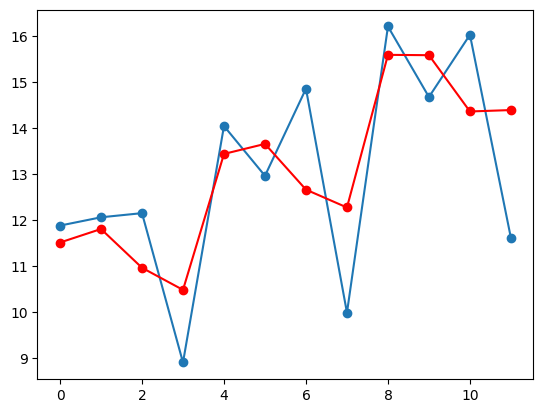

In [15]:
# =============================================================================
# VISUALIZACIÓN FINAL - REGRESIÓN LINEAL
# =============================================================================

# Graficamos los resultados de la regresión lineal
plt.plot(y_test, 'o-')                  # Azul: valores REALES
plt.plot(pred2, 'o-', color='red')      # Rojo: valores PREDICHOS (iterativos)


# =============================================================================
# CONCLUSIONES DEL NOTEBOOK
# =============================================================================
"""
RESUMEN DE MODELOS PROBADOS:
=============================

1. Árbol de Decisión:
   - Problema: Overfitting severo
   - Las predicciones son constantes (no captura la variabilidad)
   - No recomendado para este problema

2. Random Forest:
   - Mejor que el árbol único
   - Reduce overfitting con ensemble de árboles
   - MSE razonable gracias a max_depth=5

3. Regresión Lineal:
   - Modelo más simple
   - MSE aceptable (1.34 directo, 2.22 iterativo)
   - Buena opción por su simplicidad e interpretabilidad


CONCEPTOS CLAVE APRENDIDOS:
===========================

✓ Feature Engineering con LAGS para series temporales
✓ División temporal (NO aleatoria) de datos
✓ Predicción iterativa vs predicción directa
✓ Acumulación de errores en forecasting multi-paso
✓ Comparación de modelos: árboles vs ensemble vs lineal
✓ Importancia de limitar complejidad (max_depth) para evitar overfitting


PARA MEJORAR LOS RESULTADOS:
============================

- Probar otros modelos (ARIMA, Prophet, LSTM)
- Experimentar con diferentes números de lags
- Añadir features estacionales (trimestre del año)
- Aplicar transformaciones (logaritmo, diferencias)
- Usar validación cruzada específica para series temporales (TimeSeriesSplit)
"""